# MNIST Semi-Supervised Graph Convolutional Network

In [31]:
#setup

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from spektral.datasets import mnist
from spektral.layers import GraphConv
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
import numpy as np
from scipy import sparse as sp


In [22]:
#function to split data

def splitData(xTrain, yTrain, labeledSize, selectionType):
    idx = np.array([])
    if (selectionType == "Group" and labeledSize != 50000):
        size = int(labeledSize/10)
        idx = np.append(idx, np.random.choice(np.where(yTrain == 0)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 1)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 2)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 3)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 4)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 5)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 6)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 7)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 8)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 9)[0], 
                                              size, replace = False))
    elif(selectionType == "Random"):
        idx = np.random.choice(yTrain.shape[0], labeledSize, replace = False)
    else:
        idx = np.append(idx,range(0,labeledSize))
        
    idx = idx.astype(int)
    return idx

In [23]:
#create custom loss function for semi-supervised learning

from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy

def masked_categorical_crossentropy(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = K.all(K.equal(y_true, np.ones(10)), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())

    # multiply categorical_crossentropy with the mask
    loss = K.categorical_crossentropy(y_true, y_pred) * mask
    
    # take average w.r.t. the number of unmasked entries
    #return loss
    return K.sum(loss)

In [24]:
#transform output data to one hot encoding

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


In [25]:
def load_data(k_nn):
    # Load data
    X_train, y_train, X_val, y_val, X_test, y_test, adj = mnist.load_data(k=k_nn)
    X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
    N = X_train.shape[-2]      # Number of nodes in the graphs
    F = X_train.shape[-1]      # Node features dimensionality
    fltr = transform_matrix(adj)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, fltr, N, F


In [26]:
#apply matrix normalization
def transform_matrix(adj):
    
    #Transform Adjecency Matrix
    fltr = adj.copy()
    #create diagonal matrix with shape of A
    I = sp.eye(adj.shape[-1], dtype=adj.dtype)
    A_tilde = adj + I
    #normalize adjecency matrix
    #degree matrix of A raised to the -0.5
    degrees = np.power(np.array(A_tilde.sum(1)), -0.5).flatten()
    degrees[np.isinf(degrees)] = 0.
    normalized_D = sp.diags(degrees)
    #D^{0.5}*A_tilde*D^{0.5}
    fltr = normalized_D.dot(A_tilde).dot(normalized_D)
    fltr.sort_indices()
    return fltr

In [27]:
#Define parameters

# Regularization rate for l2
l2_reg = 5e-4
#Learning rate
learning_rate = 1e-3
#batch size
batch_size = 32       
#training epochs
epochs = 5
#patience
es_patience = 10
#random distribution type
selectionType = "Group"
#final class dimension
n_out = 10  


# Run Model

In [28]:
#run model for each label size 
k_nn_values = [4,8,24]
labelSize = [100, 500, 1000, 2000, 5000, 10000, 25000,50000]
loss_list = []
accuracy_list = []
for k_nn in k_nn_values:
    print("Adj Matrix with KNN K=",k_nn)
    for labeledSize in labelSize:
        
        #load data with knn parameters
        X_train, y_train, X_val, y_val, X_test, y_test, fltr, N, F = load_data(k_nn)
        # Model definition
        X_in = Input(shape=(N, F))
        # Pass A as a fixed tensor, otherwise Keras will complain about inputs of
        # different rank.
        A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))

        graph_conv = GraphConv(32,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)([X_in, A_in])
        graph_conv = GraphConv(32,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)([graph_conv, A_in])
        flatten = Flatten()(graph_conv)
        fc = Dense(512, activation='relu')(flatten)
        output = Dense(n_out, activation='softmax')(fc)


        #Build model
        model = Model(inputs=[X_in, A_in], outputs=output)
        optimizer = Adam(lr=learning_rate)
        model.compile(optimizer=optimizer,
                      loss=masked_categorical_crossentropy,
                      metrics=['accuracy'])
        #mask unlabeled data in y train
        print("labeled size:",labeledSize)
        labeledindex= splitData(X_train, y_train, labeledSize, selectionType)


        #one hote encoding
        y_val_oh = one_hot(y_val,10)
        y_train_oh = one_hot(y_train,10)
        y_test_oh = one_hot(y_test,10)

        #maske for semi-supervised
        y_train_copy = y_train_oh
        y_train_masked =  y_train_copy.copy()
        y_train_masked[[i for i in range(y_train_oh.shape[0]) if i not in labeledindex],] = np.ones(10)
        print("unlabeled:",sum(np.sum(y_train_masked,axis=1) == 10))

        # Train model
        validation_data = (X_val, y_val_oh)
        model.fit(X_train,
                  y_train_masked,
                  batch_size=batch_size,
                  validation_data=validation_data,
                  epochs=epochs,
                  callbacks=[
                      EarlyStopping(patience=es_patience, restore_best_weights=True)
                  ])

        # Evaluate model
        print('Evaluating model.')
        eval_results = model.evaluate(X_test,
                                      y_test_oh,
                                      batch_size=batch_size)
        print('Done.\n'
              'Test loss: {}\n'
              'Test acc: {}'.format(*eval_results))
        accuracy_list.append(eval_results[1])
        loss_list.append(eval_results[0])

    


Adj Matrix with KNN K= 4
labeled size: 100
unlabeled: 49900
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 152s 3ms/sample - loss: 0.3167 - accuracy: 0.1022 - val_loss: 46.5298 - val_accuracy: 0.5386
Epoch 2/5
50000/50000 [==============================] - 159s 3ms/sample - loss: 0.1175 - accuracy: 0.1205 - val_loss: 410.1124 - val_accuracy: 0.1889
Epoch 3/5
50000/50000 [==============================] - 166s 3ms/sample - loss: 0.2339 - accuracy: 0.1073 - val_loss: 61.4228 - val_accuracy: 0.5528
Epoch 4/5
50000/50000 [==============================] - 163s 3ms/sample - loss: 0.1085 - accuracy: 0.0821 - val_loss: 97.2469 - val_accuracy: 0.3260
Epoch 5/5
50000/50000 [==============================] - 162s 3ms/sample - loss: 0.1130 - accuracy: 0.0659 - val_loss: 42.1462 - val_accuracy: 0.7347
Evaluating model.
10000/10000 [==============================] - 4s 445us/sample - loss: 38.2384 - accuracy: 0.7521
Done.
Test loss: 38.238

Epoch 1/5
50000/50000 [==============================] - 175s 4ms/sample - loss: 0.2572 - accuracy: 0.1478 - val_loss: 59.6750 - val_accuracy: 0.3265
Epoch 2/5
50000/50000 [==============================] - 170s 3ms/sample - loss: 0.1662 - accuracy: 0.1167 - val_loss: 45.6738 - val_accuracy: 0.5524
Epoch 3/5
50000/50000 [==============================] - 162s 3ms/sample - loss: 0.1260 - accuracy: 0.0955 - val_loss: 59.2399 - val_accuracy: 0.4505
Epoch 4/5
50000/50000 [==============================] - 162s 3ms/sample - loss: 0.1030 - accuracy: 0.1390 - val_loss: 31.6171 - val_accuracy: 0.6913
Epoch 5/5
50000/50000 [==============================] - 168s 3ms/sample - loss: 0.0655 - accuracy: 0.1370 - val_loss: 45.0890 - val_accuracy: 0.7181
Evaluating model.
10000/10000 [==============================] - 5s 519us/sample - loss: 43.1080 - accuracy: 0.7137
Done.
Test loss: 43.108026586914065
Test acc: 0.713699996471405
labeled size: 500
unlabeled: 49500
Train on 50000 samples, validate on

50000/50000 [==============================] - 169s 3ms/sample - loss: 0.2721 - accuracy: 0.1402 - val_loss: 101.9082 - val_accuracy: 0.2002
Epoch 2/5
50000/50000 [==============================] - 159s 3ms/sample - loss: 0.1589 - accuracy: 0.0714 - val_loss: 79.4726 - val_accuracy: 0.2770
Epoch 3/5
50000/50000 [==============================] - 162s 3ms/sample - loss: 0.1895 - accuracy: 0.0935 - val_loss: 165.9154 - val_accuracy: 0.1392
Epoch 4/5
50000/50000 [==============================] - 158s 3ms/sample - loss: 0.1262 - accuracy: 0.1061 - val_loss: 50.3352 - val_accuracy: 0.4672
Epoch 5/5
50000/50000 [==============================] - 161s 3ms/sample - loss: 0.0938 - accuracy: 0.0862 - val_loss: 87.1030 - val_accuracy: 0.4382
Evaluating model.
10000/10000 [==============================] - 5s 522us/sample - loss: 89.9185 - accuracy: 0.4324
Done.
Test loss: 89.91846843261719
Test acc: 0.4323999881744385
labeled size: 500
unlabeled: 49500
Train on 50000 samples, validate on 10000 s

In [30]:
accuracy_list

[0.7521,
 0.8166,
 0.8867,
 0.894,
 0.9435,
 0.9561,
 0.9648,
 0.9749,
 0.7137,
 0.7978,
 0.8802,
 0.899,
 0.9329,
 0.9387,
 0.9677,
 0.9738,
 0.4324,
 0.8041,
 0.879,
 0.8975,
 0.893,
 0.918,
 0.9502,
 0.9577]

In [9]:
accuracy_list

[0.6918,
 0.7127,
 0.8243,
 0.9145,
 0.9407,
 0.946,
 0.9609,
 0.9702,
 0.6137,
 0.8607,
 0.859,
 0.9027,
 0.9438,
 0.9509,
 0.9605,
 0.9768,
 0.4432,
 0.7319,
 0.814,
 0.8548,
 0.929,
 0.9397,
 0.9512,
 0.9578]

In [10]:
loss_list

[47.03282225875854,
 32.408131864929196,
 34.36030977640152,
 10.840508197188377,
 8.050295121267437,
 6.377559300619364,
 4.399977871322632,
 3.3237053697526453,
 93.97234696960449,
 21.037466452646257,
 16.01455870246887,
 12.358605482459069,
 5.985084959483147,
 5.367515652704239,
 4.13941477162838,
 2.379507250738144,
 123.783032421875,
 29.221024601745604,
 20.68340307273865,
 13.363333833694458,
 7.388604710006714,
 6.610919752311706,
 4.883316806280613,
 4.337497107028961]

In [69]:
error_list = [(1-i) for i in accuracy_list]

In [26]:
error_list

[0.8220999985933304,
 0.6523000001907349,
 0.491599977016449,
 0.4025999903678894,
 0.258899986743927,
 0.16409999132156372,
 0.1298999786376953,
 0.08890002965927124]

# Supervised Learning Version


In [33]:
#Define parameters
# Regularization rate for l2
l2_reg = 5e-4
#Learning rate
learning_rate = 1e-3
#batch size
batch_size = 32       
#training epochs
epochs = 5
#patience
es_patience = 10
#random distribution type
selectionType = "Group"
#final class dimension
n_out = 10  
#load data with knn parameters
X_train, y_train, X_val, y_val, X_test, y_test, fltr, N, F = load_data(k_nn)

# # Load data
# X_train, y_train, X_val, y_val, X_test, y_test, adj = mnist.load_data()
# X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
# N = X_train.shape[-2]      # Number of nodes in the graphs
# F = X_train.shape[-1]      # Node features dimensionality
# n_out = 10  # Dimension of the target
# selectionType = "Group"

# #fltr = GraphConv.preprocess(adj)
# #fltr = normalized_laplacian(adj)


# #Transform Adjecency Matrix
# fltr = adj.copy()
# #create diagonal matrix with shape of A
# I = sp.eye(adj.shape[-1], dtype=adj.dtype)
# A_tilde = adj + I
# #normalize adjecency matrix
# #degree matrix of A raised to the -0.5
# degrees = np.power(np.array(A_tilde.sum(1)), -0.5).flatten()
# degrees[np.isinf(degrees)] = 0.
# normalized_D = sp.diags(degrees)
# #D^{0.5}*A_tilde*D^{0.5}
# fltr = normalized_D.dot(A_tilde).dot(normalized_D)
# fltr.sort_indices()

In [34]:
#run model for each label size 

labelSize = [100, 500, 1000, 2000, 5000, 10000, 25000, 50000]
loss_list = []
accuracy_list = []

for labeledSize in labelSize:
    
    # ------------Model definition
    X_in = Input(shape=(N, F))
    # Pass A as a fixed tensor, otherwise Keras will complain about inputs of
    # different rank.
    A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))

    graph_conv = GraphConv(32,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])
    graph_conv = GraphConv(32,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([graph_conv, A_in])
    flatten = Flatten()(graph_conv)
    fc = Dense(512, activation='relu')(flatten)
    output = Dense(n_out, activation='softmax')(fc)
    
    
    # ------------Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=masked_categorical_crossentropy,
                  metrics=['accuracy'])
    #model.summary()

    #mask unlabeled data in y train
    print("labeled size:",labeledSize)
    labeledindex= splitData(X_train, y_train, labeledSize, selectionType)
    
    
    
    #one hote encoding
    y_val_oh = one_hot(y_val,10)
    y_train_oh = one_hot(y_train,10)
    y_test_oh = one_hot(y_test,10)
    
    #train only on labeled data
    y_train_copy = y_train_oh
    X_train_copy = X_train
    X_train_copy = X_train_copy[labeledindex]
    y_train_copy = y_train_copy[labeledindex]
    print("X train size:",X_train_copy.shape)
    
    
    # Train model
    validation_data = (X_val, y_val_oh)
    model.fit(X_train_copy,
              y_train_copy,
              batch_size=batch_size,
              validation_data=validation_data,
              epochs=epochs,
              callbacks=[
                  EarlyStopping(patience=es_patience, restore_best_weights=True)
              ])
    
    # Evaluate model
    print('Evaluating model.')
    eval_results = model.evaluate(X_test,
                                  y_test_oh,
                                  batch_size=batch_size)
    print('Done.\n'
          'Test loss: {}\n'
          'Test acc: {}'.format(*eval_results))
    accuracy_list.append(eval_results[1])
    loss_list.append(eval_results[0])
    
    


labeled size: 100
X train size: (100, 784, 1)
Train on 100 samples, validate on 10000 samples
Epoch 1/5
100/100 [==============================] - 7s 74ms/sample - loss: 75.6523 - accuracy: 0.1300 - val_loss: 60.7989 - val_accuracy: 0.4263
Epoch 2/5
100/100 [==============================] - 5s 51ms/sample - loss: 52.7774 - accuracy: 0.5300 - val_loss: 43.7699 - val_accuracy: 0.5554
Epoch 3/5
100/100 [==============================] - 5s 51ms/sample - loss: 34.7112 - accuracy: 0.6100 - val_loss: 35.3295 - val_accuracy: 0.6532
Epoch 4/5
100/100 [==============================] - 5s 50ms/sample - loss: 24.5403 - accuracy: 0.8300 - val_loss: 29.6723 - val_accuracy: 0.6952
Epoch 5/5
100/100 [==============================] - 5s 51ms/sample - loss: 17.6419 - accuracy: 0.8000 - val_loss: 27.8804 - val_accuracy: 0.7098
Evaluating model.
10000/10000 [==============================] - 5s 488us/sample - loss: 27.0953 - accuracy: 0.7256
Done.
Test loss: 27.0953464263916
Test acc: 0.72560000419616

In [20]:
accuracy_list

[0.7454, 0.8347, 0.8933, 0.9119, 0.9391, 0.9561, 0.9658, 0.9753]

# PLOTS

In [35]:
k_nn_values = [4,8,24]
labelSize = [100, 500, 1000, 2000, 5000, 10000, 25000,50000]
k4 = [0.6918,
 0.7127,
 0.8243,
 0.9145,
 0.9407,
 0.946,
 0.9609,
 0.9702]
k8 =  [0.6137,
 0.8607,
 0.859,
 0.9027,
 0.9438,
 0.9509,
 0.9605,
 0.9768]
k24 =  [0.4432,
 0.7319,
 0.814,
 0.8548,
 0.929,
 0.9397,
 0.9512,
 0.9578]
sl= [0.7517, 0.8517, 0.8823, 0.9184, 0.9392, 0.9512, 0.9698, 0.973]
sl = [0.7454, 0.8347, 0.8933, 0.9119, 0.9391, 0.9561, 0.9658, 0.9753]

In [36]:
k4_error = [(1-i) for i in k4]
k8_error = [(1-i) for i in k8]
k24_error = [(1-i) for i in k24]
sl_error = [(1-i) for i in sl]

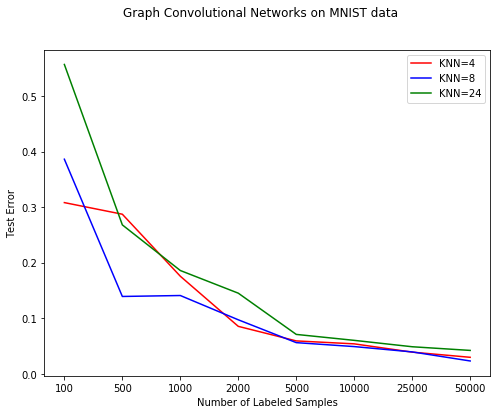

In [39]:
# create plot with all three ks
import matplotlib.pyplot as plt

#fig = plt.figure()
fig= plt.figure(figsize=(8,6))
xIdx = list(range(len(labelSize)))
plt.plot(xIdx,k4_error,'r-',label='KNN=4')
fig.suptitle('Graph Convolutional Networks on MNIST data')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Error')
plt.plot(xIdx,k8_error,'b-',label='KNN=8')
plt.plot(xIdx,k24_error,'g-',label='KNN=24')
plt.legend()
plt.xticks(xIdx,labelSize)
fig.savefig('gcn1.jpg')
plt.show()


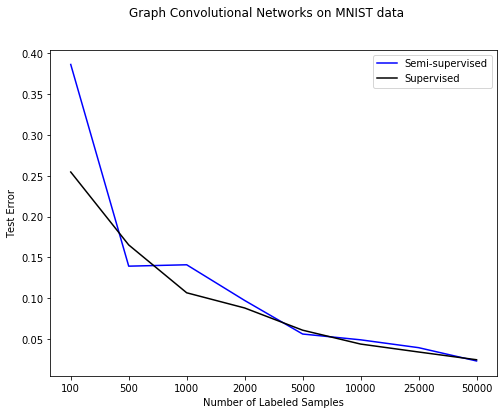

In [40]:
#compare k=8 against supervised learning
#fig = plt.figure()
fig= plt.figure(figsize=(8,6))
xIdx = list(range(len(labelSize)))
plt.plot(xIdx,k8_error,'b-',label='Semi-supervised')
fig.suptitle('Graph Convolutional Networks on MNIST data')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Error')
plt.plot(xIdx,sl_error,'black',label='Supervised')
plt.legend()
plt.xticks(xIdx,labelSize)
fig.savefig('gcn2.jpg')
plt.show()